<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Unnormalised-Mixture-of-two-Gaussians" data-toc-modified-id="Unnormalised-Mixture-of-two-Gaussians-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Unnormalised Mixture of two Gaussians</a></span><ul class="toc-item"><li><span><a href="#Applying-variational-EM-type-algorithm-to-the-unnormalised-model" data-toc-modified-id="Applying-variational-EM-type-algorithm-to-the-unnormalised-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Applying variational EM-type algorithm to the unnormalised model</a></span></li><li><span><a href="#NCE-objective-function" data-toc-modified-id="NCE-objective-function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>NCE objective function</a></span></li><li><span><a href="#First-lower-bound" data-toc-modified-id="First-lower-bound-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>First lower bound</a></span></li></ul></li></ul></div>

# Unnormalised Mixture of two Gaussians

Previously, in notebooks 1 & 2, we considered the **normalised** mixture of gaussian model family:

$$ \phi(u, z; \theta) = \frac{1}{2}(1-z) \frac{1}{\sqrt{2 \pi} \theta} e^{-\frac{u^2}{2 \theta^2}} + \frac{1}{2}z \frac{1}{\sqrt{2 \pi} \sigma_1} e^{-\frac{u^2}{2 \sigma_1^2}} $$

Below, we consider the **unnormalised** mixture of gaussian model family, with an additional scaling parameter $c$:

\begin{align}
\phi(u, z; \theta, c) & = e^{-c} \left( (1-z) e^{-\frac{u^2}{2 \theta^2}} + z e^{-\frac{u^2}{2 \sigma_1^2}} \right) \\
                   & = e^{-c} \sqrt{2 \pi} \left( (1-z)  \theta \mathcal{N}(u, \theta) + 
                                            z \sigma_1 \mathcal{N}(u;\sigma_1) \right)
\end{align}

where $z \sim \mathcal{Ber}(\frac{1}{2})$.

(note that the first family is not nested in the latter - you would need two scaling parameters, one for each unnormalised gaussian).

Integrating this family yields the partition function:

$$ Z(\theta, c) = e^{-c}\sqrt{2\pi}( \theta + \sigma_1 ) $$

Therefore, the corresponding normalised family has the form:

\begin{align} 
    p_m(u; \theta) & = \frac{\sum_{z=0}^1\phi(u, z, \theta, c)}{Z(\theta, c)} \\
                 & = \frac{e^{-c}\sqrt{2 \pi} \left( \theta \mathcal{N}(u, \theta) + 
                                            \sigma_1 \mathcal{N}(u;\sigma_1) \right)}{Z(\theta, c)} \\
                 & = \frac{\theta}{\theta + \sigma_1} \mathcal{N}(u; 0, \theta) +
                     \frac{\sigma_1}{\theta + \sigma_1} \mathcal{N}(u; 0, \sigma_1)
\end{align}

this last formula gives us a way to easily generate synthetic data. fixing $\theta = \sigma_0$, we get:

\begin{align} 
        p_x(u)  =  \mathbb{E}_{w}\left( (1-w) \mathcal{N}(u; 0, \sigma_0) + w \mathcal{N}(u; 0, \sigma_1) \right))
\end{align}

 where $ w \sim \mathcal{Ber}(\frac{\sigma_1}{\sigma_1 + \sigma_0}) $.
 
So, if $\sigma_0 = 4$ and $\sigma_1^2 = 1$, then we can toss a biased coin $ w \sim \mathcal{Ber}(\frac{1}{5}) $, and then draw a data point $x$ from the corresponding gaussian.

We can also calculate in advance the optimal value of $c$, call it $c_0$, that we want to estimate. $c_0$ should satisfy:

$$ 
Z(\sigma_0, c_0) = 1 \\
\Rightarrow \ \ \ \ \ c_0 = \frac{1}{2}\log(2\pi) + \log(\sigma_0 + \sigma_1) 
$$

For the values $\sigma_0 = 4$ and $\sigma_1^2 = 1$, this implies $c_0 \approx 2.5283764456387727$.

## Applying variational EM-type algorithm to the unnormalised model

In the previous notebooks, we demonstrated how to apply a variational EM type algorithm to the normalised MoG. The mathematical derivations in those notebooks mostly transfer to the unnormalised case. In fact, the only difference is that we need to plug in a different expression for:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) $$

the derivation for this term is very similar to the normalised case. The end result is:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) = \left[ -1, \ (1- z) \frac{u^2}{\theta^3} \right]^T $$

In order to obtain a lower bound on the first term in the NCE objective function, we need to specify a variational posterior distribution that can 'fill in' the missing values $z$.

As in the sanity check code, we use $p(z \ | \ x)$, which can be computed as:

\begin{align}
q_u(z=0 \ | \ u) & = p(z=0 \ | \ u) \\
             & = \frac{1}{1 + \exp(\frac{-u^2}{2} (\frac{1}{\sigma_1^2} + \frac{1}{\sigma_0^2}) )}
\end{align}

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from fully_observed_models import SumOfTwoUnnormalisedGaussians, SumOfTwoNormalisedGaussians
from latent_variable_model import LatentMixtureOfTwoUnnormalisedGaussians
from nce_optimiser import NCEOptimiser
from mle_optimiser import MLEOptimiser
from utils import evaluate_loss_at_param
from vnce_optimiser import VemOptimiser, ScipyMinimiseEmStep, ExactEStep, VnceLossWithAnalyticExpectations

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)
save_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/experiments/mog/unnormalised_variationalem'
os.makedirs(save_dir, exist_ok=True)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 4
sigma0 = 6  # (parameter of interest)

n = 5000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE
c0 = 0.5*np.log(2*np.pi) + np.log(sigma1 + sigma0)   # true value of scaling parameter
true_theta = np.array([c0, np.log(sigma0)])

theta0 = np.array([0, 0.7])  # initial theta
# theta0 = true_theta
alpha0 = np.array([0, 0, 0]) # initial alpha

In [5]:
true_data_dist = LatentMixtureOfTwoUnnormalisedGaussians(theta=true_theta, sigma1=sigma1, rng=rng)
X = true_data_dist.sample(n) # generate data

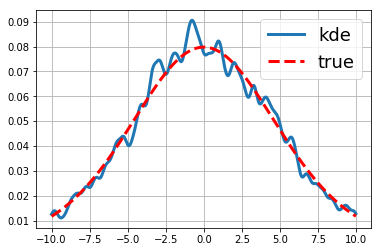

In [6]:
fig = true_data_dist.plot_sample_density_against_true_density(X, figsize=(6,4))

In [7]:
noise = GaussianNoise(mean=0, cov=sigma0**2)
Y = noise.sample(int(n*nu))

In [8]:
model = LatentMixtureOfTwoUnnormalisedGaussians(np.array([0, 0.5]), sigma1=sigma1)
nce_model = SumOfTwoUnnormalisedGaussians(np.array([0, 0.5]), sigma1=sigma1)  # for comparison
mle_model = SumOfTwoNormalisedGaussians(np.array([0]), sigma1 = sigma1)  # for comparison

In [9]:
var_dist = PolynomialSigmoidBernoulli(alpha=np.array([0,0,0]))

In [10]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [11]:
nce_optimiser = NCEOptimiser(model=nce_model, noise=noise, noise_samples=Y, nu=nu, eps=10**-20)
mle_optimiser = MLEOptimiser(model=mle_model)

In [12]:
loss_function = VnceLossWithAnalyticExpectations(model=model, 
                                                 noise=noise,
                                                 variational_q=var_dist,
                                                 E1=E1, 
                                                 E2=E2, 
                                                 E3=E3, 
                                                 E4=E4, 
                                                 E5=E5,
                                                 noise_to_data_ratio=nu)
m_step = ScipyMinimiseEmStep(do_m_step=True, optimisation_method='BFGS')
e_step = ScipyMinimiseEmStep(do_m_step=False, optimisation_method='BFGS')
optimiser = VemOptimiser(loss_function=loss_function, m_step=m_step, e_step=e_step)

In [13]:
theta_ones = np.arange(0.01, 8, 0.2)
theta_zeros = np.arange(2, 4, 0.2) 
n_theta = len(theta_ones)
n_c = len(theta_zeros)

In [14]:
# NCE & MLE objective values
J = np.zeros((n_theta, n_c))
L = np.zeros(n_theta)
for k in range(n_theta):
    
    mle_model.theta = np.log(theta_ones[k])
    L[k] = mle_optimiser.compute_L(X)
    
    nce_model.theta[1] = np.log(theta_ones[k])
    for m in range(n_c):
        nce_model.theta[0] = theta_zeros[m]
        J[k, m] = nce_optimiser.compute_J(X)

In [15]:
# Values of J1 for fixed variation q, with alpha=sigma0
alpha_2 = 0.5*((1/sigma0**2) + (1/sigma1**2))
var_dist.alpha = np.array([0, 0, alpha_2])

J1 = np.zeros((n_theta, n_c))
for k in range(n_theta):
    theta_k = np.zeros(2)
    theta_k[1] = np.log(theta_ones[k])
    for m in range(n_c):
        theta_k[0] = theta_zeros[m]
        J1[k, m] = evaluate_loss_at_param(loss_function, X, Y, theta=theta_k)

In [16]:
plot_log_theta_one = False  # CHANGE ME
if plot_log_theta_one:
    theta_ones = np.log(theta_ones)

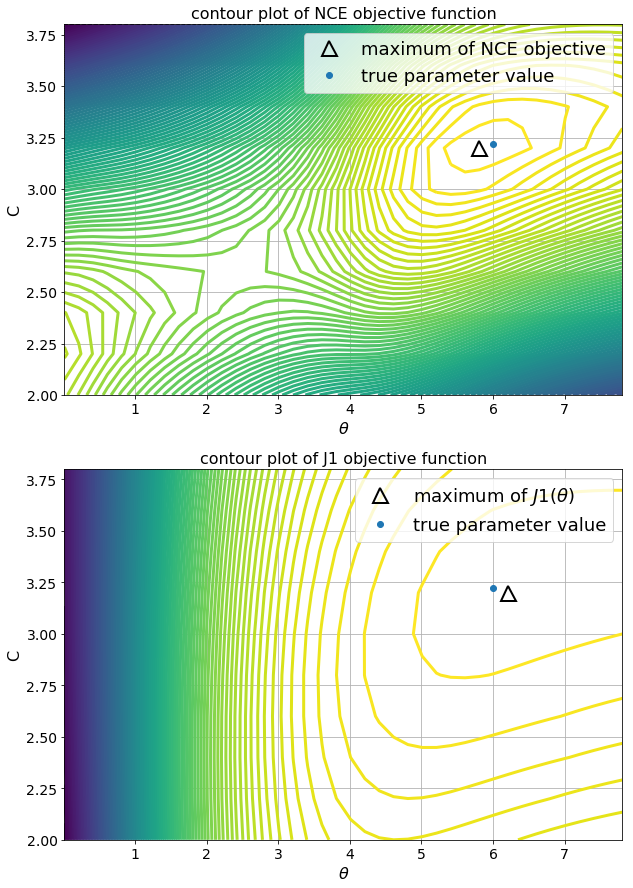

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10,15))

XX, YY = np.meshgrid(theta_ones, theta_zeros)

ax = axs[0]
# Plot true NCE objective function
CS = ax.contour(XX, YY, J.T, 100)
#plt.clabel(CS, inline=1, fontsize=10)
# Plot maximum of NCE objective
index = np.argmax(J) # this is the index for the flattened array
row = int(index/n_c)
column = index % n_c
ax.plot(theta_ones[row], theta_zeros[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE objective')

ax = axs[1]
# Plot lower bound J1 objective function
ax.contour(XX, YY, J1.T, 100)
# Plot maximum of J1 objective
index3 = np.argmax(J1) # this is the index for the flattened array
row3 = int(index3/n_c)
column3 = index3 % n_c
ax.plot(theta_ones[row3], theta_zeros[column3], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $J1(\theta)$')

#ax = ax[2]
# Plot monte carlo lower bound J1 objective function
# ax.contour(XX, YY, J1_mc.T, 100)
# Plot maximum of J1 Monte-Carlo objective
# index4 = np.argmax(J1_mc) # this is the index for the flattened array
# row4 = int(index4/n_c)
# column4 = index4 % n_c
# ax.plot(theta_ones[row4], theta_zeros[column4], marker='^', markersize=15, fillstyle='none', 
#          markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $J1(\theta)$')

# Plot True value of parameters
for a in axs:
    if plot_log_theta_one:
        a.plot(np.log(sigma0), c0,'o', label='true parameter value')
    else:
        a.plot(sigma0, c0,'o', label='true parameter value')
    
axs[0].set_title('contour plot of NCE objective function', fontsize=16)
axs[1].set_title('contour plot of J1 objective function', fontsize=16)
#axs[2].set_title('contour plot of J1 objective function using monte-carlo', fontsize=16)

axs[0].set_xlabel(r'$\theta$', fontsize=16)
axs[0].set_ylabel('C', fontsize=16)
axs[1].set_xlabel(r'$\theta$', fontsize=16)
axs[1].set_ylabel('C', fontsize=16)
#ax[2].set_xlabel(r'$\theta$', fontsize=16)
#ax[2].set_ylabel('C', fontsize=16)
axs[0].tick_params(axis='x', which='major', labelsize=14)
axs[0].tick_params(axis='y', which='major', labelsize=14)
axs[1].tick_params(axis='x', which='major', labelsize=14)
axs[1].tick_params(axis='y', which='major', labelsize=14)
#ax[2].tick_params(axis='x', which='major', labelsize=14)
#ax[2].tick_params(axis='y', which='major', labelsize=14)

axs[0].grid()
axs[1].grid()
#ax[2].grid()
axs[0].legend(loc='best', numpoints=1)
axs[1].legend(loc='best', numpoints=1)
#ax[2].legend(loc='best', numpoints=1)

fig.savefig(os.path.join(save_dir, 'contour-nceJ-exactJ1.pdf'))

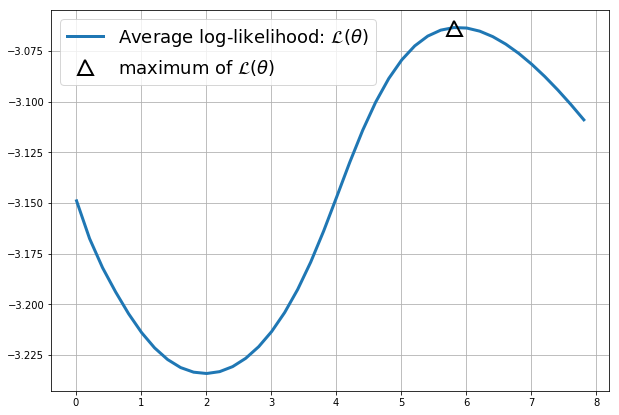

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(theta_ones, L, label=r'Average log-likelihood: $\mathcal{L}(\theta)$')
arg_max = np.argmax(L)
ax.plot(theta_ones[arg_max], L[arg_max],  marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label=r'maximum of $\mathcal{L}(\theta)$')
ax.grid()
ax.legend()

In [19]:
print('J1 is a lower bound for {}% of the parameters'.format(100* np.sum(J1 < J) / J.size))

J1 is a lower bound for 100.0% of the parameters


In [20]:
optimiser.fit(X, Y, theta0=theta0, alpha0=alpha0, stop_threshold=1e-5)

         Current function value: 1.415974
         Iterations: 7
         Function evaluations: 85
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: 1.393269
         Iterations: 11
         Function evaluations: 18
         Gradient evaluations: 18
         Current function value: 1.380404
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 1.376000
         Iterations: 10
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.374923
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Current function value: 1.374705
         Iterations: 9
         Function evaluations: 71
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: 1.374664
        

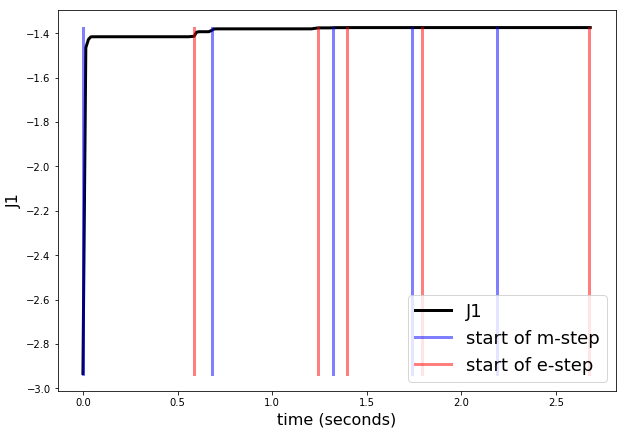

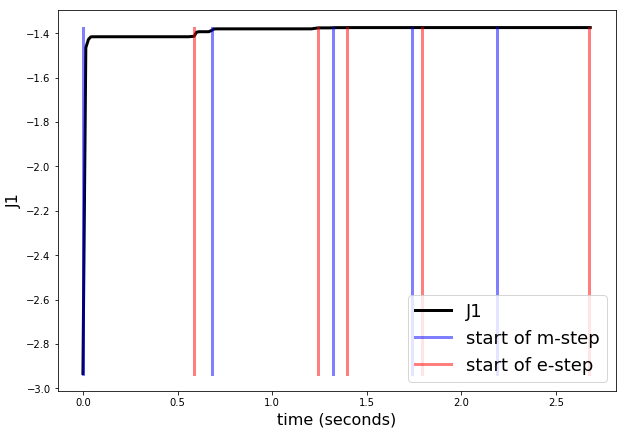

In [21]:
optimiser.plot_loss_curve()

In [22]:
nce_thetas, Js, nce_times = nce_optimiser.fit(X, theta0=theta0)

(<matplotlib.figure.Figure at 0x7f7a3a72e9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a3a74ad30>)

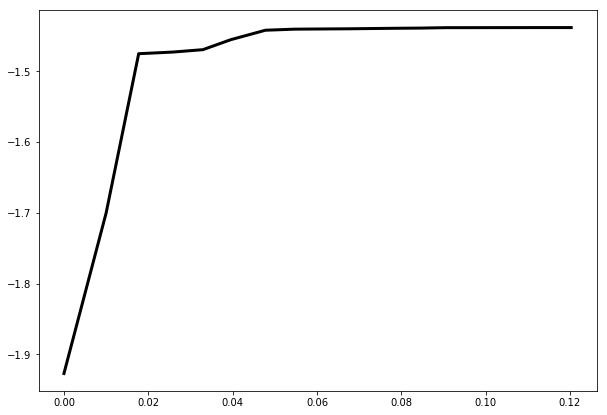

In [23]:
nce_optimiser.plot_loss_curve()

In [24]:
mle_thetas, Ls, mle_times = mle_optimiser.fit(X, theta0=theta0[1])

(<matplotlib.figure.Figure at 0x7f7a3a56e320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a3a73c710>)

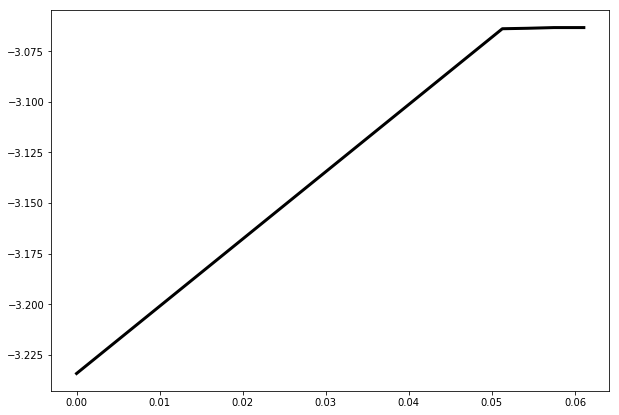

In [25]:
mle_optimiser.plot_loss_curve()

In [26]:
print('vnce parameter estimates are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(optimiser.thetas[-1][-1][0], 
                                      np.exp(optimiser.thetas[-1][-1][1])))

vnce parameter estimates are: 
scaling parameter: 3.2082260278043764 
standard deviation: 5.86783687203762


In [27]:
print('nce parameter estimates are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(nce_model.theta[0], 
                                      np.exp(nce_model.theta[1])))

nce parameter estimates are: 
scaling parameter: 2.2241158321769197 
standard deviation: 0.0005106060968364843


In [28]:
print('mle parameter estimates are: \n'
      'standard deviation: {}'.format(np.exp(mle_model.theta)))

mle parameter estimates are: 
standard deviation: [5.8760122]


In [29]:
print('True parameters are: \n'
      'scaling parameter: {} \n'
      'standard deviation: {}'.format(true_theta[0], np.exp(true_theta[1])))

True parameters are: 
scaling parameter: 3.2215236261987186 
standard deviation: 6.0
